#### Deploy a machine learning model to ACI

In [1]:
# login

! az login

The default web browser has been opened at https://login.microsoftonline.com/organizations/oauth2/v2.0/authorize. Please continue the login in the web browser. If no web browser is available or if the web browser fails to open, use device code flow with `az login --use-device-code`.
Opening in existing browser session.
[6721:6721:0100/000000.820087:ERROR:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.
[
  {
    "cloudName": "AzureCloud",
    "homeTenantId": "fb44495d-8da7-44d4-b597-6199eb799ccc",
    "id": "b1997ed0-2373-4622-83fc-102035f13ae5",
    "isDefault": true,
    "managedByTenants": [],
    "name": "Azure for Students",
    "state": "Enabled",
    "tenantId": "fb44495d-8da7-44d4-b597-6199eb799ccc",
    "user": {
      "name": "bhavyakumawat99@gmail.com",
      "type": "user"
    }
  }
]


In [2]:
# Import necessary packages

import os 
import azureml.core
from azureml.core import Workspace

# check core SDK version number

print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.36.0


In [3]:
workspace = 'doughnut-detection-ws'
subscription_id = 'b1997ed0-2373-4622-83fc-102035f13ae5'
resource_group = 'Doughnut-Detection'
location = 'centralindia'

In [5]:
# Create the workspace

ws = Workspace.create(name= workspace,
               subscription_id= subscription_id,
               resource_group= resource_group,
               create_resource_group=True,
               location=location
               )

Deploying AppInsights with name doughnutinsights36d072fa.
Deployed AppInsights with name doughnutinsights36d072fa. Took 4.9 seconds.
Deploying StorageAccount with name doughnutstorage920a5aaf5.
Deploying KeyVault with name doughnutkeyvault7eecb95c.
Deployed KeyVault with name doughnutkeyvault7eecb95c. Took 19.13 seconds.
Deployed StorageAccount with name doughnutstorage920a5aaf5. Took 23.18 seconds.
Deploying Workspace with name doughnut-detection-ws.
Deployed Workspace with name doughnut-detection-ws. Took 35.36 seconds.


In [6]:
# register model

from azureml.core.model import Model

model = Model.register( workspace= ws,
                        model_path = './saved_model/',
                        model_name = 'doughnut_detection_model')
print(model.name, model.id, model.version, sep='\t')

Registering model doughnut_detection_model
doughnut_detection_model	doughnut_detection_model:1	1


In [7]:
%%writefile score.py

import json
import numpy as np
import tensorflow as tf
import collections
import six
import PIL.Image as Image
import PIL.ImageColor as ImageColor
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont
from azureml.monitoring import ModelDataCollector
import logging
logging.basicConfig(level=logging.DEBUG)

# Loading the model
def init():
    global model, prediction_dc
    # path to the model folder (./azureml-models/$MODEL_NAME/$VERSION)
    # folder containing all deployed models (./azureml-models)
    
    model_name = 'doughnut_detection_model'
    model_path = "./azureml-models/{}/{}/saved_model".format(model_name, "1")
    model = tf.saved_model.load(model_path)
        
    prediction_dc = ModelDataCollector(model_name, designation="predictions", feature_names=["input", "output", "count"])



def run(raw_data):
    """ input <- an image """
        
    data = np.array(json.loads(raw_data)['data'])
    
    # The input needs to be a tensor
    input_tensor = tf.convert_to_tensor(data, dtype=tf.uint8)
    # The model expects a batch of images, so add an axis with `tf.newaxis`
    input_tensor = input_tensor[tf.newaxis, ...]
    # make prediction
    detections = model(input_tensor)
    
    # The following processing is only for single image
    detection_boxes = tf.squeeze(detections['detection_boxes'], [0])
    detection_masks = tf.squeeze(detections['detection_masks'], [0])
    # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
    real_num_detection = tf.cast(detections['num_detections'][0], tf.int32)
    detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
    detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
    detection_masks_reframed = reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, data.shape[0], data.shape[1])
    detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)

    # Follow the convention by adding back the batch dimension
    detections['detection_masks'] = tf.expand_dims(detection_masks_reframed, 0)

    detections['num_detections'] = int(detections['num_detections'][0])
    detections['detection_classes'] = detections['detection_classes'][0].numpy().astype(np.uint8)

    detections['detection_boxes'] = detections['detection_boxes'][0].numpy()
    detections['detection_scores'] = detections['detection_scores'][0].numpy()
    detections['detection_masks'] = detections['detection_masks'][0].numpy()
    
    json_serializable_detections = {}
    
    for key in detections.keys():
        if type(detections[key]) == np.ndarray:
            json_serializable_detections[key] = detections[key].tolist()
        elif tf.is_tensor(detections[key]):
            json_serializable_detections[key] = detections[key].numpy().tolist()
        else:
            json_serializable_detections[key] = detections[key]
            
    image_np_with_detections = data.astype('uint8')
    
    PATH_TO_LABELS = 'labelmap.pbtxt'
    category_index = create_category_index()
    
    score_thresh = 0.50
    
    # count number of donuts
    count_classes = {'Strawberry Frosted':0, 'Chocolate Frosted': 0, 'Boston Cream':0, 'Sugar Glazed':0 }
    
    for classes in detections["detection_classes"][detections["detection_scores"]>=score_thresh]:
        count_classes[category_index[classes]['name']] +=1
    
    visualize_boxes_and_labels_on_image_array(
                            image_np_with_detections,
                            detections['detection_boxes'],
                            detections['detection_classes'],
                            detections['detection_scores'],
                            category_index,
                            instance_masks=detections.get('detection_masks'),
                            use_normalized_coordinates=True,
                            max_boxes_to_draw=30,
                            min_score_thresh=score_thresh)
    
    output_image = image_np_with_detections.tolist()
    #output = { 'output_image': output_image, 'count':count_classes, 'raw_prediction': json_serializable_detections }
    output = { 'output_image': output_image, 'count':count_classes}
    
    # collect data to Blobs 
    input_image = json.loads(raw_data)['data']
    prediction_dc.collect([input_image, output_image, count_classes]) #this call is saving our prediction data into Azure Blob
    
    # you can return any data type as long as it is JSON-serializable
    return output


def reframe_image_corners_relative_to_boxes(boxes):
    """Reframe the image corners ([0, 0, 1, 1]) to be relative to boxes.
    The local coordinate frame of each box is assumed to be relative to
    its own for corners.
    """
    ymin, xmin, ymax, xmax = (boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3])

    height = tf.maximum(ymax - ymin, 1e-4)
    width = tf.maximum(xmax - xmin, 1e-4)

    ymin_out = (0 - ymin) / height
    xmin_out = (0 - xmin) / width
    ymax_out = (1 - ymin) / height
    xmax_out = (1 - xmin) / width
    return tf.stack([ymin_out, xmin_out, ymax_out, xmax_out], axis=1)

def reframe_box_masks_to_image_masks(box_masks, boxes, image_height, image_width, resize_method='bilinear'):
    """Transforms the box masks back to full image masks.
    Embeds masks in bounding boxes of larger masks whose shapes correspond to
    image shape.
    """
    resize_method = 'nearest' if box_masks.dtype == tf.uint8 else resize_method
    
    def reframe_box_masks_to_image_masks_default():
        """The default function when there are more than 0 box masks."""

        num_boxes = tf.shape(box_masks)[0]
        box_masks_expanded = tf.expand_dims(box_masks, axis=3)
        
        resized_crops = tf.image.crop_and_resize(
            image=box_masks_expanded,
            boxes=reframe_image_corners_relative_to_boxes(boxes),
            box_indices=tf.range(num_boxes),
            crop_size=[image_height, image_width],
            method=resize_method,
            extrapolation_value=0)
        return tf.cast(resized_crops, box_masks.dtype)

    image_masks = tf.cond(
      tf.shape(box_masks)[0] > 0,
      reframe_box_masks_to_image_masks_default,
      lambda: tf.zeros([0, image_height, image_width, 1], box_masks.dtype))
    return tf.squeeze(image_masks, axis=3)


def visualize_boxes_and_labels_on_image_array(
    image,
    boxes,
    classes,
    scores,
    category_index,
    instance_masks=None,
    instance_boundaries=None,
    keypoints=None,
    keypoint_scores=None,
    keypoint_edges=None,
    track_ids=None,
    use_normalized_coordinates=False,
    max_boxes_to_draw=20,
    min_score_thresh=.5,
    agnostic_mode=False,
    line_thickness=4,
    mask_alpha=.4,
    groundtruth_box_visualization_color='black',
    skip_boxes=False,
    skip_scores=False,
    skip_labels=False,
    skip_track_ids=False):
    """Overlay labeled boxes on an image with formatted scores and label names.

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3) with overlaid boxes.
    """
    # Create a display string (and color) for every box location, group any boxes
    # that correspond to the same location.
    
    
    STANDARD_COLORS = [
    'AliceBlue', 'Chartreuse', 'Aqua', 'Aquamarine', 'Azure', 'Beige', 'Bisque',
    'BlanchedAlmond', 'BlueViolet', 'BurlyWood', 'CadetBlue', 'AntiqueWhite',
    'Chocolate', 'Coral', 'CornflowerBlue', 'Cornsilk', 'Crimson', 'Cyan',
    'DarkCyan', 'DarkGoldenRod', 'DarkGrey', 'DarkKhaki', 'DarkOrange',
    'DarkOrchid', 'DarkSalmon', 'DarkSeaGreen', 'DarkTurquoise', 'DarkViolet',
    'DeepPink', 'DeepSkyBlue', 'DodgerBlue', 'FireBrick', 'FloralWhite',
    'ForestGreen', 'Fuchsia', 'Gainsboro', 'GhostWhite', 'Gold', 'GoldenRod',
    'Salmon', 'Tan', 'HoneyDew', 'HotPink', 'IndianRed', 'Ivory', 'Khaki',
    'Lavender', 'LavenderBlush', 'LawnGreen', 'LemonChiffon', 'LightBlue',
    'LightCoral', 'LightCyan', 'LightGoldenRodYellow', 'LightGray', 'LightGrey',
    'LightGreen', 'LightPink', 'LightSalmon', 'LightSeaGreen', 'LightSkyBlue',
    'LightSlateGray', 'LightSlateGrey', 'LightSteelBlue', 'LightYellow', 'Lime',
    'LimeGreen', 'Linen', 'Magenta', 'MediumAquaMarine', 'MediumOrchid',
    'MediumPurple', 'MediumSeaGreen', 'MediumSlateBlue', 'MediumSpringGreen',
    'MediumTurquoise', 'MediumVioletRed', 'MintCream', 'MistyRose', 'Moccasin',
    'NavajoWhite', 'OldLace', 'Olive', 'OliveDrab', 'Orange', 'OrangeRed',
    'Orchid', 'PaleGoldenRod', 'PaleGreen', 'PaleTurquoise', 'PaleVioletRed',
    'PapayaWhip', 'PeachPuff', 'Peru', 'Pink', 'Plum', 'PowderBlue', 'Purple',
    'Red', 'RosyBrown', 'RoyalBlue', 'SaddleBrown', 'Green', 'SandyBrown',
    'SeaGreen', 'SeaShell', 'Sienna', 'Silver', 'SkyBlue', 'SlateBlue',
    'SlateGray', 'SlateGrey', 'Snow', 'SpringGreen', 'SteelBlue', 'GreenYellow',
    'Teal', 'Thistle', 'Tomato', 'Turquoise', 'Violet', 'Wheat', 'White',
    'WhiteSmoke', 'Yellow', 'YellowGreen'
]

    
    
    box_to_display_str_map = collections.defaultdict(list)
    box_to_color_map = collections.defaultdict(str)
    box_to_instance_masks_map = {}
    box_to_instance_boundaries_map = {}
    box_to_keypoints_map = collections.defaultdict(list)
    box_to_keypoint_scores_map = collections.defaultdict(list)
    box_to_track_ids_map = {}
    if not max_boxes_to_draw:
        max_boxes_to_draw = boxes.shape[0]
    for i in range(boxes.shape[0]):
        if max_boxes_to_draw == len(box_to_color_map):
            break
        if scores is None or scores[i] > min_score_thresh:
            box = tuple(boxes[i].tolist())
            if instance_masks is not None:
                box_to_instance_masks_map[box] = instance_masks[i]
            if instance_boundaries is not None:
                box_to_instance_boundaries_map[box] = instance_boundaries[i]
            if keypoints is not None:
                box_to_keypoints_map[box].extend(keypoints[i])
            if keypoint_scores is not None:
                box_to_keypoint_scores_map[box].extend(keypoint_scores[i])
            if track_ids is not None:
                box_to_track_ids_map[box] = track_ids[i]
            if scores is None:
                box_to_color_map[box] = groundtruth_box_visualization_color
            else:
                display_str = ''
                if not skip_labels:
                    if not agnostic_mode:
                        if classes[i] in six.viewkeys(category_index):
                            class_name = category_index[classes[i]]['name']
                        else:
                            class_name = 'N/A'
                        display_str = str(class_name)
                if not skip_scores:
                    if not display_str:
                        display_str = '{}%'.format(round(100*scores[i]))
                    else:
                        display_str = '{}: {}%'.format(display_str, round(100*scores[i]))
                if not skip_track_ids and track_ids is not None:
                    if not display_str:
                        display_str = 'ID {}'.format(track_ids[i])
                    else:
                        display_str = '{}: ID {}'.format(display_str, track_ids[i])
                box_to_display_str_map[box].append(display_str)
                if agnostic_mode:
                    box_to_color_map[box] = 'DarkOrange'
                elif track_ids is not None:
                    prime_multipler = _get_multiplier_for_color_randomness()
                    box_to_color_map[box] = STANDARD_COLORS[
                        (prime_multipler * track_ids[i]) % len(STANDARD_COLORS)]
                else:
                    box_to_color_map[box] = STANDARD_COLORS[
                        classes[i] % len(STANDARD_COLORS)]

    # Draw all boxes onto image.
    for box, color in box_to_color_map.items():
        ymin, xmin, ymax, xmax = box
        if instance_masks is not None:
            draw_mask_on_image_array(
              image,
              box_to_instance_masks_map[box],
              color=color,
              alpha=mask_alpha
            )
        if instance_boundaries is not None:
            draw_mask_on_image_array(
              image,
              box_to_instance_boundaries_map[box],
              color='red',
              alpha=1.0
            )
        draw_bounding_box_on_image_array(
            image,
            ymin,
            xmin,
            ymax,
            xmax,
            color=color,
            thickness=0 if skip_boxes else line_thickness,
            display_str_list=box_to_display_str_map[box],
            use_normalized_coordinates=use_normalized_coordinates)
        if keypoints is not None:
            keypoint_scores_for_box = None
            if box_to_keypoint_scores_map:
                keypoint_scores_for_box = box_to_keypoint_scores_map[box]
            draw_keypoints_on_image_array(
              image,
              box_to_keypoints_map[box],
              keypoint_scores_for_box,
              min_score_thresh=min_score_thresh,
              color=color,
              radius=line_thickness / 2,
              use_normalized_coordinates=use_normalized_coordinates,
              keypoint_edges=keypoint_edges,
              keypoint_edge_color=color,
              keypoint_edge_width=line_thickness // 2)

    return image


def create_category_index():
    category_index = {1: {'id': 1, 'name': 'Strawberry Frosted'}, 2: {'id': 2, 'name': 'Chocolate Frosted'}, 3: {'id': 3, 'name': 'Boston Cream'}, 4: {'id': 4, 'name': 'Sugar Glazed'}}
    
    return category_index


def draw_mask_on_image_array(image, mask, color='red', alpha=0.4):
    """Draws mask on an image.
    """
    if image.dtype != np.uint8:
        raise ValueError('`image` not of type np.uint8')
    if mask.dtype != np.uint8:
        raise ValueError('`mask` not of type np.uint8')
    if image.shape[:2] != mask.shape:
        raise ValueError('The image has spatial dimensions %s but the mask has '
                         'dimensions %s' % (image.shape[:2], mask.shape))
    rgb = ImageColor.getrgb(color)
    pil_image = Image.fromarray(image)

    solid_color = np.expand_dims(
          np.ones_like(mask), axis=2) * np.reshape(list(rgb), [1, 1, 3])
    pil_solid_color = Image.fromarray(np.uint8(solid_color)).convert('RGBA')
    pil_mask = Image.fromarray(np.uint8(255.0*alpha*(mask > 0))).convert('L')
    pil_image = Image.composite(pil_solid_color, pil_image, pil_mask)
    np.copyto(image, np.array(pil_image.convert('RGB')))
    
    
def draw_bounding_box_on_image_array(image,
                                     ymin,
                                     xmin,
                                     ymax,
                                     xmax,
                                     color='red',
                                     thickness=4,
                                     display_str_list=(),
                                     use_normalized_coordinates=True):
    """Adds a bounding box to an image (numpy array).
    """
    image_pil = Image.fromarray(np.uint8(image)).convert('RGB')
    draw_bounding_box_on_image(image_pil, ymin, xmin, ymax, xmax, color,
                             thickness, display_str_list,
                             use_normalized_coordinates)
    np.copyto(image, np.array(image_pil))
    
    
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color='red',
                               thickness=4,
                               display_str_list=(),
                               use_normalized_coordinates=True):
    """Adds a bounding box to an image.
    """
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    if use_normalized_coordinates:
        (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
    else:
        (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
    if thickness > 0:
        draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
               (left, top)],
               width=thickness,
               fill=color)
    try:
        font = ImageFont.truetype('arial.ttf', 24)
    except IOError:
        font = ImageFont.load_default()

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = bottom + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle(
            [(left, text_bottom - text_height - 2 * margin), (left + text_width,
                                                              text_bottom)],
            fill=color)
        draw.text(
            (left + margin, text_bottom - text_height - margin),
            display_str,
            fill='black',
            font=font)
        text_bottom -= text_height - 2 * margin

Overwriting score.py


In [8]:
# Create configuration file
# specify the number of CPUs and gigabyte of RAM needed for your ACI container

from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=3, 
                                               memory_gb=4,
                                               description='Detect donuts with Tensorflow',
                                               dns_name_label='donut-detection-endpoint',
                                               auth_enabled=True,
                                               collect_model_data=True,
                                               location=location)

In [9]:
#Deploy in ACI

import uuid
from azureml.core.webservice import Webservice
from azureml.core.model import InferenceConfig
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.model import Model

#curated_env_name = 'AzureML-tensorflow-2.4-ubuntu18.04-py37-cpu-inference'
#myenv = Environment.get(workspace=ws, name=curated_env_name)
#myenv.inferencing_stack_version='latest'

myenv = Environment('donut-env')
myenv.python.conda_dependencies = CondaDependencies.create(conda_packages=['numpy'],
                                                           pip_packages=['azureml-core',
                                                                         'azureml-defaults',
                                                                         'azureml-monitoring',
                                                                         'azureml-telemetry',
                                                                         'inference-schema[numpy-support]',
                                                                         'tensorflow',
                                                                         'pillow'
                                                                        ])



#myenv = Environment.from_conda_specification(name='donut-env', file_path='./AzureML-TensorFlow-2.2-GPU/conda_dependencies.yml')
inference_config = InferenceConfig(entry_script="score.py", environment=myenv)

service_name = 'donut-detection-svc-' + str(uuid.uuid4())[:4]
service = Model.deploy(workspace=ws, 
                       name=service_name, 
                       models=[model], 
                       inference_config=inference_config, 
                       deployment_config=aciconfig)

service.wait_for_deployment(show_output=True)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2022-01-03 08:32:16+05:30 Creating Container Registry if not exists..
2022-01-03 08:42:16+05:30 Registering the environment..
2022-01-03 08:42:21+05:30 Building image..
2022-01-03 08:50:07+05:30 Generating deployment configuration.
2022-01-03 08:50:10+05:30 Submitting deployment to compute..
2022-01-03 08:50:19+05:30 Checking the status of deployment donut-detection-svc-20d6..
2022-01-03 08:52:38+05:30 Checking the status of inference endpoint donut-detection-svc-20d6.
Succeeded
ACI service creation operation finished, operation "Succeeded"


In [10]:
# Get the scoring web service's HTTP endpoint, which accepts REST client calls
print(service.scoring_uri)

http://donut-detection-endpoint.centralindia.azurecontainer.io/score


#### Get deployment logs

In [11]:
# Choose the webservice you are interested in
print(ws.webservices)


{'donut-detection-svc-20d6': AciWebservice(workspace=Workspace.create(name='doughnut-detection-ws', subscription_id='b1997ed0-2373-4622-83fc-102035f13ae5', resource_group='Doughnut-Detection'), name=donut-detection-svc-20d6, image_id=None, compute_type=None, state=ACI, scoring_uri=None, tags=http://donut-detection-endpoint.centralindia.azurecontainer.io/score, properties={}, created_by={'hasInferenceSchema': 'False', 'hasHttps': 'False'})}


In [12]:
from azureml.core import Webservice

service = Webservice(ws, 'donut-detection-svc-20d6')
print(service.get_logs())

2022-01-03T03:22:29,237973500+00:00 - gunicorn/run 
2022-01-03T03:22:29,238033900+00:00 - rsyslog/run 
2022-01-03T03:22:29,239527600+00:00 - iot-server/run 
Dynamic Python package installation is disabled.
Starting HTTP server
2022-01-03T03:22:29,249731200+00:00 - nginx/run 
EdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...
2022-01-03T03:22:29,420635800+00:00 - iot-server/finish 1 0
2022-01-03T03:22:29,423562500+00:00 - Exit code 1 is normal. Not restarting iot-server.
Starting gunicorn 20.1.0
Listening at: http://127.0.0.1:31311 (86)
Using worker: sync
worker timeout is set to 300
Booting worker with pid: 115
2022-01-03 03:22:30.977914: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /azureml-envs/azureml_bc8139b43197572336031b8f6e304e6d/lib:/azureml-envs/azureml_bc8139b43197572336031b8f6e30

#### Make REST client calls

In [27]:
# test web service
import urllib.request
from PIL import Image
import numpy as np
import json
import glob
import random


images = glob.glob('./test set/*')
path = random.choice(images)
img = Image.open(path)
img = img.resize(size=(400, 400))
img = np.array(img) 

# Request data goes here
data = { "data": img.tolist()
}

body = str.encode(json.dumps(data))

url = 'http://donut-detection-endpoint.centralindia.azurecontainer.io/score'
api_key = '0IgOuJCMnxq5JAgr7Olw78YPaXSQWLa8' # Replace this with the API key for the web service
headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key)}

req = urllib.request.Request(url, body, headers)

try:
    response = urllib.request.urlopen(req)
    result = response.read()
    predictions = json.loads(result)
    
except urllib.error.HTTPError as error:
    print("The request failed with status code: " + str(error.code))

    # Print the headers - they include the requert ID and the timestamp, which are useful for debugging the failure
    print(error.info())
    print(json.loads(error.read().decode("utf8", 'ignore')))

In [28]:
predictions.keys()

dict_keys(['output_image', 'count'])

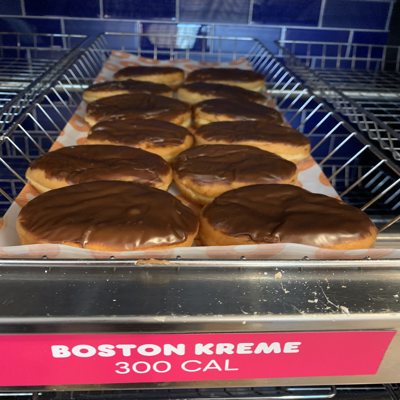

In [31]:
# input image
input_img = Image.open(path)
input_img.resize((400, 400))

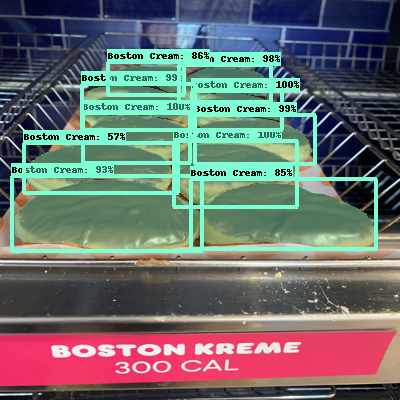

In [32]:
from PIL import Image
import numpy as np

# Convert the pixels into an array using numpy
array = np.array(predictions["output_image"], dtype=np.uint8)

# Use PIL to create an image from the new array of pixels
new_image = Image.fromarray(array)
#new_image.save('new.png')
new_image

In [33]:
predictions["count"]

{'Strawberry Frosted': 0,
 'Chocolate Frosted': 0,
 'Boston Cream': 10,
 'Sugar Glazed': 0}

#### Collected data from models in production
* The path to the output data in the blob follows this syntax:


In [ ]:
# /modeldata/<subscriptionid>/<resourcegroup>/<workspace>/<webservice>/<model>/<version>/<designation>/<year>/<month>/<day>/data.csv